In [1]:
import sys
import geoopt
import torch
import numpy as np
import pytest
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

Use `geoopt` to do line search optimization where parameters are constrained to manifolds. 

As example we will try to find the basis of a matrix $A$ in which it has the smallest 1-norm by minimizing $\|XAY\|_1$ where $X,Y$ are orthogonal

In [2]:
sphere = geoopt.manifolds.Sphere()
torus = geoopt.manifolds.ProductManifold(*[(sphere,10)]*2)
point = torus.random(20)
point


Tensor on (Sphere)x(Sphere) manifold containing:
tensor([ 0.3784, -0.1772, -0.2530,  0.4151,  0.2453, -0.2891, -0.0475,  0.2688,
         0.1931, -0.5775,  0.3122, -0.3493, -0.1610,  0.0338,  0.3798, -0.4868,
         0.0781, -0.5759,  0.1513, -0.1077])

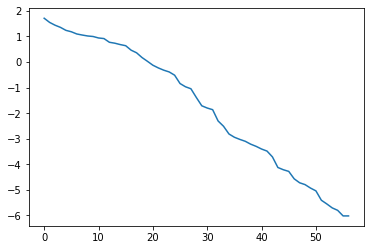

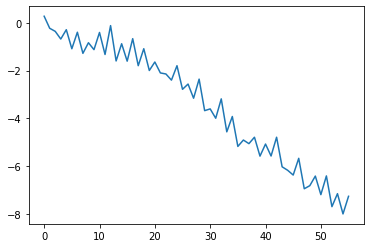

In [45]:
# as test do orthogonal Procrustes problem, because we know closed-form solution
torch.manual_seed(42)
(n,m) = (10,20)
BATCH_SIZE=16
stiefel = geoopt.manifolds.Stiefel()
A = torch.randn(n,m,dtype=torch.float64)
Q = stiefel.random((n,n),dtype=torch.float64)
B = Q@A

with torch.no_grad():
    X = stiefel.random((BATCH_SIZE,n,n),dtype=torch.float64)
    X.requires_grad=True
closure_calls = 0
def closure():
    global closure_calls
    closure_calls+=1
    optim.zero_grad()
    loss = (X@A-B).norm()
    loss.backward()
    return loss.item()
optim = geoopt.optim.RiemannianLineSearch([X],line_search_method='wolfe',c1=1e-3,c2=0.5)
losses=[]
closure_calls_list=[]
for i in range(1000):
    losses.append(optim.step(closure))
    closure_calls_list.append(closure_calls)
    if optim.last_step_size is None:
        break

plt.plot(np.log10(losses))
plt.figure()
log_step_sizes = (np.log10([x for x in optim.step_size_history if x is not None]))
plt.plot(log_step_sizes)
plt.show()

5%|▍         | 47/1000 [00:00<00:03, 310.98it/s]


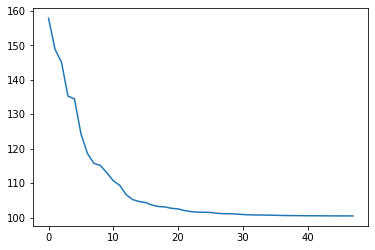

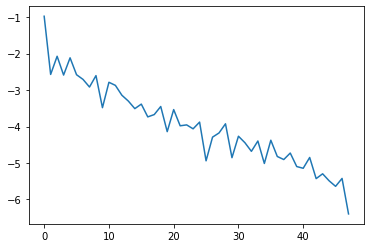

In [35]:
(n,m) = (10,20)
BATCH_SIZE=16
A = torch.randn(n,m)
stiefel = geoopt.manifolds.Stiefel()

X = stiefel.random((n,n))
X.requires_grad=True
Y = stiefel.random((m,m))
Y.requires_grad=True

stief_prod = geoopt.manifolds.ProductManifold((stiefel,(n,n)),(stiefel,(m,m)))
XY = stief_prod.random(n**2+m**2)
XY.requires_grad=True

def closure():
    optim.zero_grad()

    loss = (X@A@Y).norm(p=1)
    loss.backward()

    return loss.item()

optim = geoopt.optim.RiemannianLineSearch([X,Y],line_search_method='wolfe')
losses = []
for i in tqdm(range(1000)):
    losses.append(optim.step(closure))
    if optim.step_size_history[-1]<1e-6:
        break


plt.plot(losses)
plt.figure()
log_step_sizes = (np.log10([x if (x is not None) else 1 for x in optim.step_size_history]))
plt.plot(log_step_sizes)
plt.show()

In [5]:
optim.derphi_(0.1)

tensor(287.0525, grad_fn=<AddBackward0>)